In [1]:
EXPERIMENT = '04-05'
N_SPLITS = 5
SEED = 1
CLIP_UPPER_RATE = 1.5
CLIP_LOWER_RATE = 1.0
Y_THRESHOLD = 200
EMBEDDER = 'doc2vec'
DECOMPOSER = None  # 'pca', 'svd' or None

In [2]:
from collections import defaultdict
import configparser
from functools import partial
from itertools import chain
import json
import logging
import os
import pickle
import re
import sys
import time

SINCE = time.time()

from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error as mse, f1_score, precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearnex import patch_sklearn
patch_sklearn()

config = configparser.ConfigParser()
INI_FILEPATH = os.path.join(os.path.expanduser('~'), 'aiquest2021-assesment', 'config.ini')
config.read(INI_FILEPATH)
if config['FOLDER']['SCRIPTS'] not in sys.path:
    sys.path.append(config['FOLDER']['SCRIPTS'])
from logging_util import get_logger, timer
from feature_engineering import make_or_load_features, make_or_load_name_vector

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
output_dir = os.path.join(config['FOLDER']['EXPERIMENTS'], EXPERIMENT)
os.makedirs(output_dir)

In [4]:
logger = get_logger(__name__, os.path.join(output_dir, 'log.log'))

# Loading

In [5]:
with timer('Load dataset', logger):
    train = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'train.csv'))
    test = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'test.csv'))
    sample_submit = pd.read_csv(os.path.join(config['FOLDER']['INPUT'], 'sample_submit.csv'))

# Feature engineering

In [6]:
train_path = os.path.join(config['FOLDER']['FEATURES'], 'train_features.csv')
test_path = os.path.join(config['FOLDER']['FEATURES'], 'test_features.csv')

In [7]:
X, X_test = make_or_load_features(train, test, train_path, test_path, logger)

In [8]:
X

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,1.0,4.0,0,0,1,1,...,0,0,0,1,2016.0,7.0,2016.0,7.0,2016.0,7.0
1,1,2,1.0,0,1.0,1.0,1,1,1,1,...,1,1,0,0,2016.0,9.0,2015.0,12.0,2017.0,3.0
2,2,2,2.0,0,1.0,1.0,1,2,1,1,...,2,2,1,0,2016.0,6.0,2016.0,5.0,2017.0,8.0
3,3,2,1.0,0,1.0,1.0,1,3,1,1,...,0,3,0,1,2014.0,3.0,2012.0,6.0,2017.0,9.0
4,4,2,1.0,0,1.0,1.0,1,2,1,1,...,2,4,0,0,2015.0,8.0,2015.0,3.0,2017.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55578,55578,4,1.5,0,1.0,1.0,1,2,1,1,...,2,95,0,0,2013.0,2.0,2013.0,1.0,2017.0,9.0
55579,55579,2,1.0,0,1.0,1.0,2,4,0,1,...,3,181,0,0,2015.0,11.0,2015.0,1.0,2016.0,10.0
55580,55580,2,1.0,0,1.0,1.0,0,3,1,1,...,0,33,0,0,2016.0,3.0,2016.0,2.0,2017.0,4.0
55581,55581,1,1.5,0,1.0,1.0,2,0,1,1,...,0,251,0,0,2016.0,10.0,2016.0,4.0,2017.0,4.0


In [9]:
X_test

,id,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,...,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_review_year,last_review_month
0,0,6,2.0,0,2.0,2.0,1,5,1,1,...,4,88,0,0,2017.0,1.0,2016.0,8.0,2017.0,9.0
1,1,3,1.0,0,1.0,1.0,2,0,1,1,...,0,16,0,0,2016.0,8.0,2014.0,9.0,2017.0,5.0
2,2,2,1.0,0,0.0,1.0,0,2,0,1,...,2,90,0,0,NaN,NaN,2012.0,10.0,NaN,NaN
3,3,4,1.0,0,1.0,2.0,1,2,0,1,...,2,44,0,0,NaN,NaN,2013.0,1.0,NaN,NaN
4,4,3,1.5,0,1.0,2.0,1,0,1,1,...,0,129,0,0,2015.0,8.0,2014.0,12.0,2016.0,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18523,18523,4,1.0,0,2.0,2.0,1,2,1,1,...,2,109,0,0,NaN,NaN,2009.0,11.0,NaN,NaN
18524,18524,2,1.0,0,2.0,1.0,0,4,0,1,...,3,22,0,1,2017.0,1.0,2017.0,1.0,2017.0,4.0
18525,18525,5,1.5,0,2.0,2.0,0,4,1,1,...,3,181,0,0,NaN,NaN,2014.0,9.0,NaN,NaN
18526,18526,2,1.0,0,1.0,2.0,1,2,1,1,...,2,158,0,0,2016.0,4.0,2014.0,3.0,2017.0,5.0


In [10]:
X.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]
X_test.columns = [re.sub(r"[:;/']", '', c) for c in X.columns]

In [11]:
# Clustering
area_features = ['latitude', 'longitude']

# Onehot encoding
categorical_features = ['cancellation_policy', 'bed_type', 'city', 'neighbourhood', 'property_type',
                        'room_type', 'zipcode5', 'zipcode_1st_digit']

# They do not need to be encoded
int_flag_features = ['cleaning_fee', 'host_has_profile_pic', 'host_identity_verified',
                     'instant_bookable', 'has_thumbnail', 'zipcode_imputed']

# Already one-hot style
amenity_onehot_features = [c for c in X.columns if c.startswith('has_') and c.endswith('_amenity')]

discrete_features = categorical_features + int_flag_features + amenity_onehot_features

# Scaling, transformation
continuous_features = [
    c for c in X.columns
    if c not in discrete_features + area_features + ['id', 'y']
]

In [12]:
%%time
# Reduce dimension & whitening
## training
decomposer = PCA(n_components=0.9, random_state=SEED, whiten=True).fit(X[amenity_onehot_features])
X_amenity_components = decomposer.transform(X[amenity_onehot_features])
amenity_components_columns = [f'amenity_x{i + 1}' for i in range(decomposer.n_components_)]
X_amenity_components = pd.DataFrame(data=X_amenity_components,
                                    columns=amenity_components_columns)
X = pd.concat([X, X_amenity_components], axis=1)
# X.drop(columns=amenity_onehot_features, inplace=True)
X_test_amenity_components = decomposer.transform(X_test[amenity_onehot_features])
X_test_amenity_components = pd.DataFrame(data=X_test_amenity_components,
                                         columns=amenity_components_columns)
X_test = pd.concat([X_test, X_test_amenity_components], axis=1)
# X_test.drop(columns=amenity_onehot_features, inplace=True)

Wall time: 579 ms


In [13]:
%%time
vec_train, vec_test = make_or_load_name_vector(train=train,
                                               test=test,
                                               feature_dir=config['FOLDER']['FEATURES'],
                                               logger=logger,
                                               embedder=EMBEDDER)
vec_train.shape, vec_test.shape

Wall time: 922 ms


((55583, 100), (18528, 100))

In [14]:
%%time
if DECOMPOSER is None:
    assert(EMBEDDER not in ('count', 'tfidf'))
    vec_columns = vec_train.columns.tolist()
elif DECOMPOSER == 'pca':
    decomposer = PCA(n_components=0.9, random_state=SEED).fit(vec_train)
    vec_columns = [f'component{i + 1}' for i in range(decomposer.n_components_)]
    vec_train = pd.DataFrame(data=decomposer.transform(vec_train), columns=vec_columns)
    vec_test = pd.DataFrame(data=decomposer.transform(vec_test), columns=vec_columns)
elif DECOMPOSER == 'svd':
    n_components = min(100, int(vec_train.shape[1] / 2))
    decomposer = TruncatedSVD(n_components=n_components, random_state=SEED).fit(vec_train)
    vec_columns = [f'component{i + 1}' for i in range(n_components)]
    vec_train = pd.DataFrame(data=decomposer.transform(vec_train), columns=vec_columns)
    vec_test = pd.DataFrame(data=decomposer.transform(vec_test), columns=vec_columns)
else:
    raise ValueError(DECOMPOSER)
vec_train.shape, vec_test.shape

Wall time: 0 ns


((55583, 100), (18528, 100))

In [15]:
%%time
X = pd.concat([X, vec_train], axis=1)
X_test = pd.concat([X_test, vec_test], axis=1)
X.shape, X_test.shape

Wall time: 31.2 ms


((55583, 296), (18528, 296))

In [16]:
passthrough_features = amenity_onehot_features \
                     + amenity_components_columns \
                     + int_flag_features \
                     + area_features \
                     + vec_columns

In [17]:
def get_classifier(continuous_features, discrete_features, passthrough_features, random_state):
    continuous_preprocessor = Pipeline(
        steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]
    )
    categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')
    preprocessor = ColumnTransformer(
        transformers=[
            ('categorical', categorical_preprocessor, continuous_features),
            ('continuous', continuous_preprocessor, discrete_features),
            ('others', 'passthrough', passthrough_features)
        ]
    )
    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(random_state=random_state,
                                              max_iter=1000,
                                              n_jobs=-1,
                                              class_weight='balanced'))
        ]
    )

# Cross validation

## Preparation

In [18]:
y_min, y_max = train['y'].min(), train['y'].max()  # clipping に必要

In [19]:
# ターゲットは対数変換する
y = train.set_index('id').loc[X['id']]['y']
y_log = np.log(y)
y_log

id
0        4.927254
1        3.737670
2        4.174387
3        5.111988
4        5.105945
           ...   
55578    5.828946
55579    3.401197
55580    4.605170
55581    3.637586
55582    3.912023
Name: y, Length: 55583, dtype: float64

In [20]:
# Stratified K-fold 用
y_labels = pd.cut(y_log, bins=3, labels=range(3))
y_labels

id
0        1
1        1
2        1
3        2
4        2
        ..
55578    2
55579    1
55580    1
55581    1
55582    1
Name: y, Length: 55583, dtype: category
Categories (3, int64): [0 < 1 < 2]

In [21]:
y_threshold = np.log(Y_THRESHOLD)
y_threshold

5.298317366548036

In [22]:
id_test = X_test['id'].values
id_test

array([    0,     1,     2, ..., 18525, 18526, 18527], dtype=int64)

In [23]:
train.set_index('id', inplace=True)

## Training models

In [24]:
splitter = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1
    logger.debug('Start fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

    # 訓練データと検証データに分割
    id_train = X.iloc[train_idx]['id'].values
    X_train = X.iloc[train_idx].drop(columns=['id'])
    y_train = y_log[train_idx].values
    id_valid = X.iloc[vaild_idx]['id'].values
    X_valid = X.iloc[vaild_idx].drop(columns=['id'])
    y_valid = y_log[vaild_idx].values
    
    # モデルの訓練
    ## 分類モデルの訓練
    with timer('Training: classifier', logger):
        y_train_clf = 1 * (y_train > y_threshold)
        y_valid_clf = 1 * (y_valid > y_threshold)
        classifier = get_classifier(continuous_features=continuous_features,
                                    discrete_features=discrete_features,
                                    passthrough_features=passthrough_features,
                                    random_state=SEED)
        classifier.fit(X_train, y_train_clf)
    ## 分類モデルの評価
    with timer('Evaluate classifier', logger):
        pred_train_clf = classifier.predict(X_train)
        logger.debug('Training f1 score: {:.6f}'.format(f1_score(y_train_clf, pred_train_clf)))
        logger.debug('Training precision: {:.6f}'.format(precision_score(y_train_clf, pred_train_clf)))
        pred_valid_clf = classifier.predict(X_valid)
        logger.debug('Validation f1 score: {:.6f}'.format(f1_score(y_valid_clf, pred_valid_clf)))
        logger.debug('Validation precision: {:.6f}'.format(precision_score(y_valid_clf, pred_valid_clf)))
    ## `y` 予測モデルの訓練
    with timer('Training regressor', logger):
        class1_mask = y_train > y_threshold
        estimator0 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator0.fit(X_train[~class1_mask], y_train[~class1_mask], categorical_feature=discrete_features)
        estimator1 = LGBMRegressor(n_estimators=300,
                                   random_state=SEED,
                                   n_jobs=-1,
                                   learning_rate=0.1,
                                   importance_type='gain')
        estimator1.fit(X_train[class1_mask], y_train[class1_mask], categorical_feature=discrete_features)
        
    # 予測結果を保存する
    with timer('Prediction', logger):
        # 訓練データ
        proba_train = classifier.predict_proba(X_train)
        pred_train0 = estimator0.predict(X_train)
        pred_train1 = estimator1.predict(X_train)
        pred_train = pred_train0 * proba_train[:, 0] + pred_train1 * proba_train[:, 1]
        pred_train = pd.DataFrame(data=pred_train, columns=['pred'])
        pred_train['pred'] = np.exp(pred_train['pred'])
        pred_train['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # 検証データ
        proba_valid = classifier.predict_proba(X_valid)
        pred_valid0 = estimator0.predict(X_valid)
        pred_valid1 = estimator1.predict(X_valid)
        pred_valid = pred_valid0 * proba_valid[:, 0] + pred_valid1 * proba_valid[:, 1]
        pred_valid = pd.DataFrame(data=pred_valid, columns=['pred'])
        pred_valid['pred'] = np.exp(pred_valid['pred'])
        pred_valid['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
        # テストデータ
        proba_test = classifier.predict_proba(X_test.drop(columns=['id']))
        pred_test0 = estimator0.predict(X_test.drop(columns=['id']))
        pred_test1 = estimator1.predict(X_test.drop(columns=['id']))
        pred_test = pred_test0 * proba_test[:, 0] + pred_test1 * proba_test[:, 1]
        pred_test = pd.DataFrame(data=pred_test, columns=['pred'])
        pred_test['pred'] = np.exp(pred_test['pred'])
        pred_test['pred'].clip(lower=y_min * CLIP_LOWER_RATE, upper=y_max * CLIP_UPPER_RATE, inplace=True)
    with timer('Save prediction', logger):
        ## 訓練データ
        pred_train['id'] = id_train
        pred_train.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'), index=False)
        ## 検証データ
        pred_valid['id'] = id_valid
        pred_valid.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'), index=False)
        ## テストデータ
        pred_test['id'] = id_test
        pred_test.to_csv(os.path.join(output_dir, f'cv_fold{num_fold}_test.csv'), index=False)
    ## モデルの保存
    with timer('Save model', logger):
        filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
        with open(filepath_fold_model, 'wb') as f:
            pickle.dump({
                'class0': estimator0,
                'class1': estimator1,
                'classifier': classifier
            }, f)
    logger.debug('Complete fold {} ({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using cate

## Evaluation

In [25]:
rmse = partial(mse, squared=False)

In [26]:
metrics = defaultdict(list)

### Training set

In [27]:
pred_train_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_training.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} training loss={:.7f}'.format(num_fold, cv_loss))
    metrics['train_losses'].append(cv_loss)
    pred_train_dfs.append(pred_df)

metrics['train_losses_avg'] = np.mean(metrics['train_losses'])
metrics['train_losses_std'] = np.std(metrics['train_losses'])

logger.info('CV training loss: average={:.7f}, std={:.7f}' \
            .format(metrics['train_losses_avg'], metrics['train_losses_std']))

2021-08-07 03:22:44,596 - __main__ - INFO - CV fold 1 training loss=76.3887729
2021-08-07 03:22:44,626 - __main__ - INFO - CV fold 2 training loss=75.1343171
2021-08-07 03:22:44,653 - __main__ - INFO - CV fold 3 training loss=75.4967832
2021-08-07 03:22:44,680 - __main__ - INFO - CV fold 4 training loss=74.2514865
2021-08-07 03:22:44,705 - __main__ - INFO - CV fold 5 training loss=73.4570276
2021-08-07 03:22:44,707 - __main__ - INFO - CV training loss: average=74.9456774, std=1.0119097


In [28]:
pred_train = pd.concat(pred_train_dfs).groupby('id').sum()
pred_train = pred_train / N_SPLITS
pred_train['actual'] = train.loc[pred_train.index, 'y'].values
pred_train.to_csv(os.path.join(output_dir, 'prediction_train.csv'))

In [29]:
train_loss = rmse(pred_train['actual'], pred_train['pred'])
metrics['train_loss'] = train_loss
logger.info('Training loss: {:.7f}'.format(train_loss))

2021-08-07 03:22:44,939 - __main__ - INFO - Training loss: 86.4955846


### Validation set

In [30]:
pred_valid_dfs = []
for i in range(N_SPLITS):
    num_fold = i + 1
    # Read cv result
    pred_df = pd.read_csv(os.path.join(output_dir, f'cv_fold{num_fold}_validation.csv'))
    pred_df['actual'] = train.loc[pred_df['id'], 'y'].values
    cv_loss = rmse(pred_df['actual'], pred_df['pred'])
    logger.info('CV fold {} validation loss={:.7f}'.format(num_fold, cv_loss))
    metrics['valid_losses'].append(cv_loss)
    pred_valid_dfs.append(pred_df)

metrics['valid_losses_avg'] = np.mean(metrics['valid_losses'])
metrics['valid_losses_std'] = np.std(metrics['valid_losses'])

logger.info('CV validation loss: average={:.7f}, std={:.7f}' \
            .format(metrics['valid_losses_avg'], metrics['valid_losses_std']))

2021-08-07 03:22:44,970 - __main__ - INFO - CV fold 1 validation loss=106.6689379
2021-08-07 03:22:44,986 - __main__ - INFO - CV fold 2 validation loss=108.0465907
2021-08-07 03:22:45,001 - __main__ - INFO - CV fold 3 validation loss=110.6833248
2021-08-07 03:22:45,018 - __main__ - INFO - CV fold 4 validation loss=110.0453812
2021-08-07 03:22:45,035 - __main__ - INFO - CV fold 5 validation loss=112.6458291
2021-08-07 03:22:45,036 - __main__ - INFO - CV validation loss: average=109.6180128, std=2.0809428


In [31]:
pred_valid = pd.concat(pred_valid_dfs).groupby('id').sum()
pred_valid = pred_valid / N_SPLITS
pred_valid['actual'] = train.loc[pred_valid.index, 'y'].values
pred_valid.to_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [32]:
valid_loss = rmse(pred_valid['actual'], pred_valid['pred'])
metrics['valid_loss'] = valid_loss
logger.info('Validation loss: {:.7f}'.format(valid_loss))

2021-08-07 03:22:45,260 - __main__ - INFO - Validation loss: 196.8167889


In [33]:
with open(os.path.join(output_dir, 'metrics.json'), 'w') as f:
    json.dump(metrics, f)

C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\nndropout\miniconda3\envs\aiquest2021-assesment\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


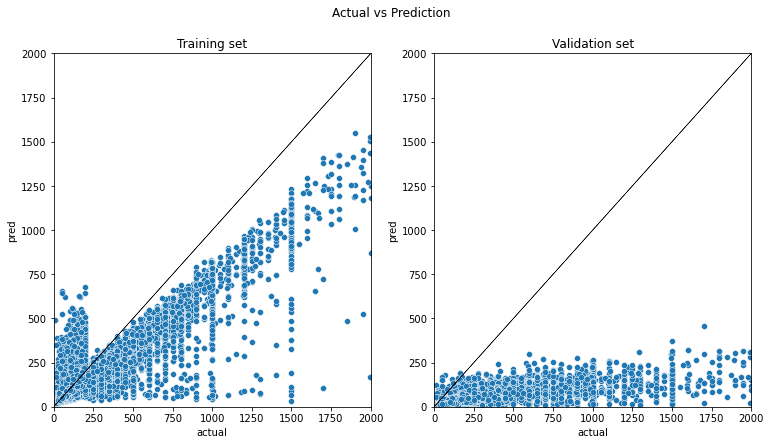

In [34]:
fig = plt.figure(figsize=(12.5, 6.5))
plt.suptitle('Actual vs Prediction')

plt.subplot(1, 2, 1)
ax = sns.scatterplot(pred_train['actual'], pred_train['pred'])
plt.plot(pred_train['actual'], pred_train['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
ax.set_title('Training set');
# plt.axes().set_aspect('equal')
plt.subplot(1, 2, 2)
ax = sns.scatterplot(pred_valid['actual'], pred_valid['pred'])
plt.plot(pred_valid['actual'], pred_valid['actual'], color='black', linewidth=0.5)
ax.set_xlim(0, 2000)
ax.set_ylim(0, 2000)
plt.title('Validation set');

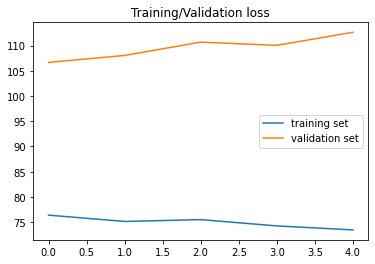

In [35]:
plt.plot(metrics['train_losses'], label='training set')
plt.plot(metrics['valid_losses'], label='validation set')
plt.title('Training/Validation loss')
plt.legend();

# Submission

In [36]:
pred_test_dfs = [pd.read_csv(os.path.join(output_dir, f'cv_fold{i + 1}_test.csv')) for i in range(N_SPLITS)]

In [37]:
pred_test = pd.concat(pred_test_dfs).groupby('id').sum()
pred_test = pred_test / N_SPLITS

In [38]:
pred_test.to_csv(os.path.join(output_dir, f'{EXPERIMENT}_submission.csv'), header=None)

# Visualization

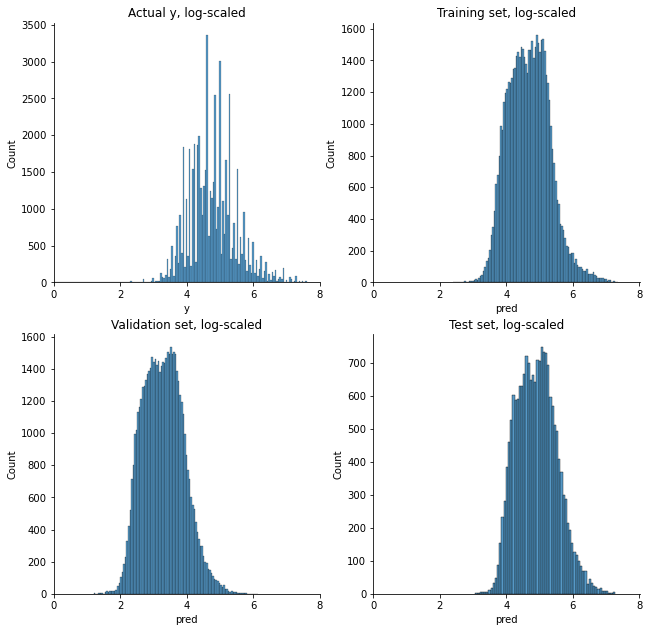

In [39]:
ylim_min, ylim_max = np.log(y_min * CLIP_LOWER_RATE), np.log(y_max * CLIP_UPPER_RATE)
fig = plt.figure(figsize=(10.5, 10.5))
plt.subplot(2, 2, 1)
ax = sns.histplot(y_log)
ax.set_title('Actual y, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 2)
ax = sns.histplot(np.log(pred_train['pred']))
ax.set_title('Training set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 3)
ax = sns.histplot(np.log(pred_valid['pred']))
ax.set_title('Validation set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

plt.subplot(2, 2, 4)
ax = sns.histplot(np.log(pred_test['pred']))
ax.set_title('Test set, log-scaled')
ax.set_xlim(ylim_min, ylim_max)
sns.despine()

fig.savefig(os.path.join(output_dir, 'figure.png'))

In [40]:
logger.debug('Complete({:.3f} seconds passed)'.format(num_fold, time.time() - SINCE))

# Feature importance

In [41]:
pd.options.display.float_format = '{:.5f}'.format

In [42]:
models = []
for i, (train_idx, vaild_idx) in enumerate(splitter.split(X=X, y=y_labels)):
    num_fold = i + 1

    ## モデルの保存
    filepath_fold_model = os.path.join(output_dir, f'cv_fold{num_fold}_model.pkl')
    with open(filepath_fold_model, 'rb') as f:
        model = pickle.load(f)
    models.append(model)

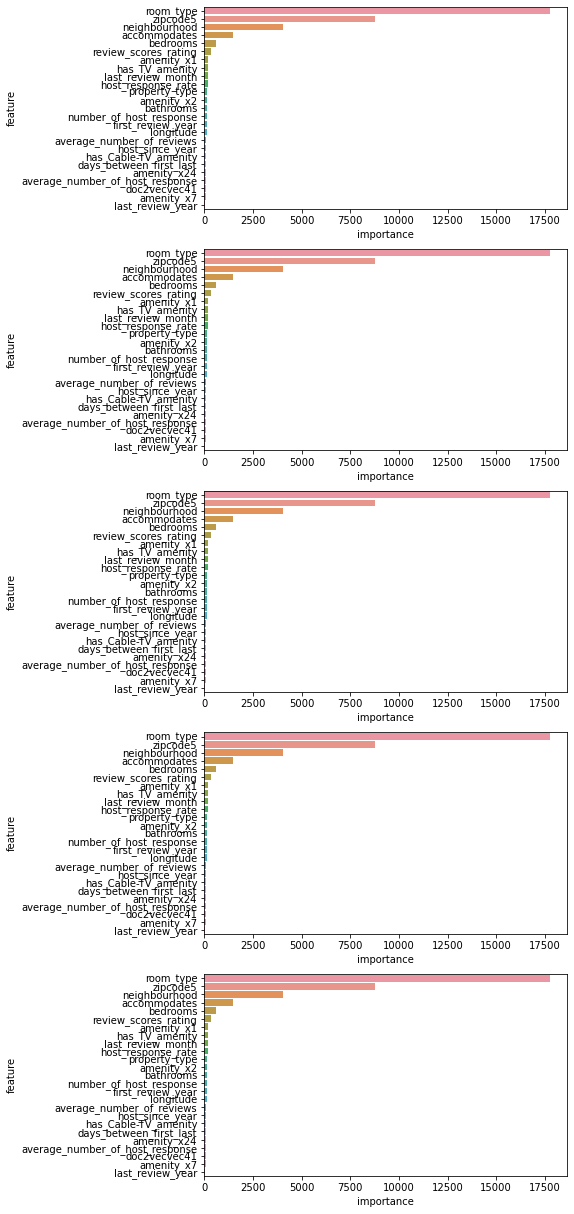

In [43]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class0'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

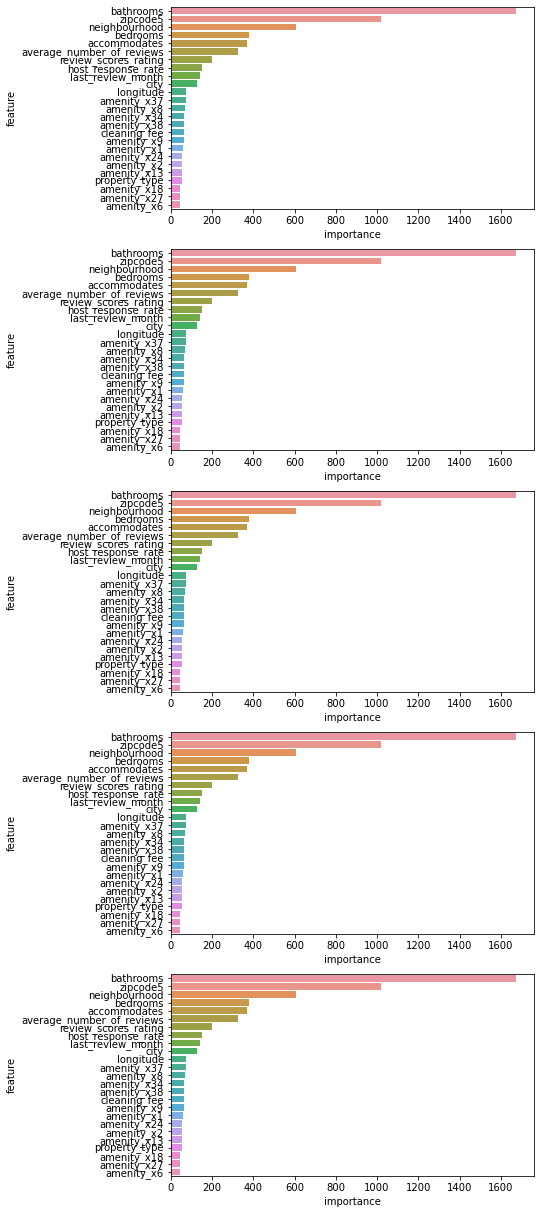

In [44]:
fig = plt.figure(figsize=(6.5, 21.5))
for i in range(N_SPLITS):
    plt.subplot(5, 1, i + 1)
    imp_df = pd.DataFrame(data=model['class1'].feature_importances_, columns=['importance'])
    imp_df['feature'] = X_train.columns.tolist()
    imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
    sns.barplot(data=imp_df.head(25), y='feature', x='importance')
fig.savefig(os.path.join(output_dir, 'feature_importance0.png'))

# Error

In [45]:
pred_valid = pd.read_csv(os.path.join(output_dir, 'prediction_valid.csv'))

In [46]:
pred_valid['diff'] = pred_valid['pred'] - pred_valid['actual']

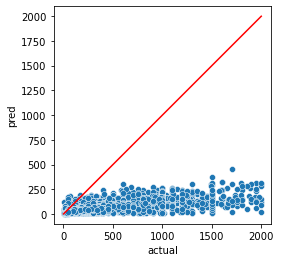

In [47]:
fig = plt.figure()
plt.axes().set_aspect('equal')
ax = sns.scatterplot(data=pred_valid, x='actual', y='pred')
ax = sns.lineplot(data=pred_valid, x='actual', y='actual', color='red')
fig.savefig(os.path.join(output_dir, 'compare_actual_prediction.png'))

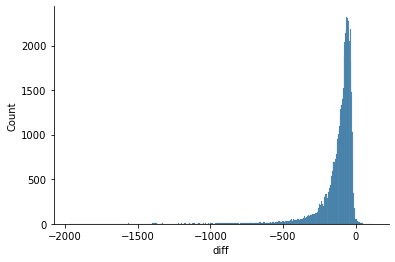

In [48]:
pred_valid.describe()
sns.histplot(data=pred_valid, x='diff')
sns.despine()

In [49]:
diff_df = pd.merge(X, pred_valid[['id', 'diff']]).set_index('id')

In [50]:
%%time
import sweetviz
report = sweetviz.analyze(diff_df, target_feat='diff', pairwise_analysis='off')
report.show_html(os.path.join(output_dir, ('sweetviz_error_report.html')))

                                             |          | [  0%]   00:00 -> (? left)

Report C:\Users\nndropout\aiquest2021-assesment\experiments\04-05\sweetviz_error_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Wall time: 2min 20s


In [51]:
pd.options.display.max_rows = 50
pd.options.display.max_columns = diff_df.shape[1]

In [52]:
diff_df.sort_values('diff').head(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [53]:
diff_df.sort_values('diff').tail(50)

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [54]:
diff_df.corr()

,accommodates,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,latitude,longitude,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,has_Coffee-maker_amenity,has__amenity,has_Beach-essentials_amenity,has_Ethernet-connection_amenity,has_Extra-pillows-and-blankets_amenity,has_Wide-entryway_amenity,has_Laptop-friendly-workspace_amenity,has_Pets-live-on-this-property_amenity,has_Lake-access_amenity,has_Crib_amenity,has_TV_amenity,has_Smoking-allowed_amenity,has_Waterfront_amenity,has_Other_amenity,has_Changing-table_amenity,has_Ground-floor-access_amenity,has_Oven_amenity,has_Baby-bath_amenity,has_Carbon-monoxide-detector_amenity,has_Paid-parking-off-premises_amenity,has_Bathtub_amenity,has_Heating_amenity,has_Pocket-wifi_amenity,has_Ski-inSki-out_amenity,has_Handheld-shower-head_amenity,has_Kitchen_amenity,has_Self-Check-In_amenity,has_24-hour-check-in_amenity,has_Long-term-stays-allowed_amenity,has_Free-parking-on-premises_amenity,has_Garden-or-backyard_amenity,has_Beachfront_amenity,has_translation-missing-en.hosting_amenity_49_amenity,has_Wide-clearance-to-shower-&-toilet_amenity,has_Firm-mattress_amenity,has_Dishwasher_amenity,has_translation-missing-en.hosting_amenity_50_amenity,has_High-chair_amenity,has_Cat(s)_amenity,has_EV-charger_amenity,has_Fireplace-guards_amenity,has_Essentials_amenity,has_BBQ-grill_amenity,has_Smartlock_amenity,has_Single-level-home_amenity,has_Buzzerwireless-intercom_amenity,has_Gym_amenity,has_Room-darkening-shades_amenity,has_Wireless-Internet_amenity,has_Suitable-for-events_amenity,has_Doorman-Entry_amenity,has_Lock-on-bedroom-door_amenity,has_Smoke-detector_amenity,has_Shampoo_amenity,has_Elevator-in-building_amenity,has_Table-corner-guards_amenity,has_Lockbox_amenity,has_Luggage-dropoff-allowed_amenity,has_Safety-card_amenity,has_Wide-hallway-clearance_amenity,has_Accessible-height-bed_amenity,has_Firm-matress_amenity,has_Microwave_amenity,has_Smart-lock_amenity,has_Doorman_amenity,has_Outlet-covers_amenity,has_Other-pet(s)_amenity,has_Familykid-friendly_amenity,has_Flat_amenity,has_Step-free-access_amenity,has_Cooking-basics_amenity,has_Washer_amenity,has_Hot-water_amenity,has_Air-purifier_amenity,has_Grab-rails-for-shower-and-toilet_amenity,has_First-aid-kit_amenity,has_Air-conditioning_amenity,has_Dryer_amenity,has_Disabled-parking-spot_amenity,has_Wheelchair-accessible_amenity,has_Keypad_amenity,has_Babysitter-recommendations_amenity,has_Host-greets-you_amenity,has_Hair-dryer_amenity,has_-smooth-pathway-to-front-door_amenity,has_Window-guards_amenity,has_Flat-smooth-pathway-to-front-door_amenity,has_Patio-or-balcony_amenity,has_Accessible-height-toilet_amenity,has_Dog(s)_amenity,has_Washer--Dryer_amenity,has_Wide-doorway_amenity,has_Wide-clearance-to-bed_amenity,has_Path-to-entrance-lit-at-night_amenity,has_Elevator_amenity,has_Cable-TV_amenity,has_Pack-’n-Playtravel-crib_amenity,has_Private-entrance_amenity,has_Refrigerator_amenity,has_Stair-gates_amenity,has_Indoor-fireplace_amenity,has_Bathtub-with-shower-chair_amenity,has_Internet_amenity,has_Iron_amenity,has_Breakfast_amenity,has_Children’s-dinnerware_amenity,has_Baby-monitor_amenity,has_Dishes-and-silverware_amenity,has_Fixed-grab-bars-for-shower-&-toilet_amenity,has_Private-living-room_amenity,has_Stove_amenity,has_Well-lit-path-to-entrance_amenity,has_Hot-tub_amenity,has_Hangers_amenity,has_Pool_amenity,has_Pets-allowed_amenity,has_Private-bathroom_amenity,has_Free-parking-on-street_amenity,has_Children’s-books-and-toys_amenity,has_Hot-water-kettle_amenity,has_Fire-extinguisher_amenity,has_Bed-linens_amenity,has_Game-console_amenity,has_Cleaning-before-checkout_amenity,days_between_first_last,average_number_of_reviews,number_of_host_response,average_number_of_host_response,zipcode_1st_digit,zipcode5,zipcode_imputed,has_thumbnail,first_review_year,first_review_month,host_since_year,host_since_month,last_rev

In [55]:
diff_df.corr().sort_values('diff')['diff'].head(50)

accommodates                           -0.47133
bedrooms                               -0.45178
bathrooms                              -0.41577
beds                                   -0.39203
room_type                              -0.25845
has_Familykid-friendly_amenity         -0.18840
has_Indoor-fireplace_amenity           -0.16607
has_TV_amenity                         -0.15766
has_Cable-TV_amenity                   -0.15306
has_Dryer_amenity                      -0.13940
amenity_x1                             -0.13718
has_Washer_amenity                     -0.13642
has_Suitable-for-events_amenity        -0.13305
doc2vecvec51                           -0.12002
amenity_x3                             -0.11182
has_thumbnail                          -0.10885
doc2vecvec41                           -0.10346
doc2vecvec21                           -0.10160
doc2vecvec64                           -0.09062
doc2vecvec100                          -0.08974
doc2vecvec20                           -

In [56]:
from lightgbm import LGBMRegressor
estimator = LGBMRegressor(random_state=SEED, n_jobs=-1, importance_type='gain').fit(diff_df.drop(columns=['diff']), diff_df['diff'])

In [57]:
imp_df = pd.DataFrame(data=estimator.feature_importances_, columns=['importance'])

In [58]:
imp_df['feature'] = estimator.feature_name_

In [59]:
imp_df.sort_values(['importance', 'feature'], ascending=False, inplace=True)
imp_df

,importance,feature
3,1009275620.19531,bedrooms
1,545232920.00000,bathrooms
0,497084217.00000,accommodates
13,308025405.79688,longitude
18,273096315.60156,room_type
...,...,...
107,0.00000,has_Accessible-height-toilet_amenity
79,0.00000,has_Accessible-height-bed_amenity
103,0.00000,has_-smooth-pathway-to-front-door_amenity
280,0.00000,doc2vecvec86


In [60]:
imp_df.to_csv(os.path.join(output_dir, 'diff_feature_importances.csv'), index=False)